# Overview

The NLP model completes the Dealroom based model. It provides an independent prediction, trained on the same set of companies as the main model bpifrance_deeptech_analysis, completed with text from:

+ the 'tagline' field of the main dataset (initially retrieved from the dealroom API)
+ the "description field of the meta tags of the companies' websites (if any)

**This document is specifically about the NLP model**

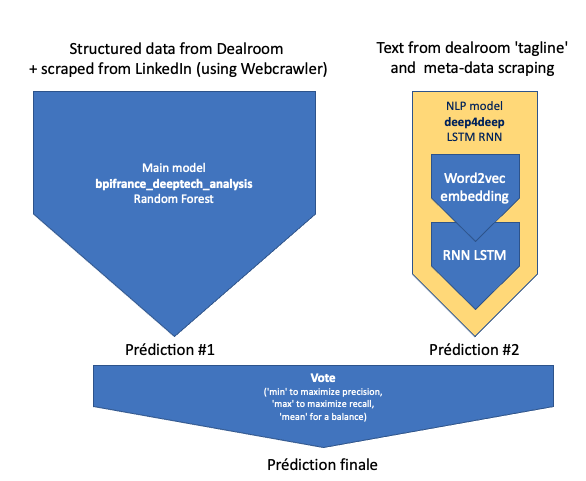

In [3]:
from IPython.display import Image
Image("img/2_models_voting.png")

The NLP package is available at:
https://github.com/ClemenceK/deep4deep

The main model package is available at:
https://github.com/ClemenceK/bpifrance_deeptech_analysis

---
# Building the training data


## module text_retrieval
The routine in the \_\_main__ of text_retrieval.py uses a file named "data2020-12-03.csv" (feel free to change the name; this file must be in a folder named "raw_data" inside the project folder (same level as deep4deep module folder) and is the typical file of data extracted from the dealroom API by the main module.
It builds a new file by scraping the description in the meta tag of a website (when available) and add the tagline from dealroom.
Scraping takes an hour or so, so only use occasionnaly when retraining the model on a new, enlarged dataset.

Note: in the get_meta_description function, when sites throw an error, we try again to scrape them without SSL certificate

⚠️⚠️⚠️ **We don't think there is a security issue in this scraping, but if you disagree, remove these lines.**


This module also has unused functions, esp. to retrieve news from the dealroom API.
The dealroom API key would be stored locally by each user in a `.env` file, listed in `.gitignore`.

## module scanr_retrieval
This unused module has functions to scrape the ScanR API: https://scanr.enseignementsup-recherche.gouv.fr/

## module description_dataframe_preparation
This is a data preparation routine that is actually called by the LSTM_Meta_trainer, when initializing its own training dataset:

`self.df_meta_categorical = data_prep()`

---
# Training of the model

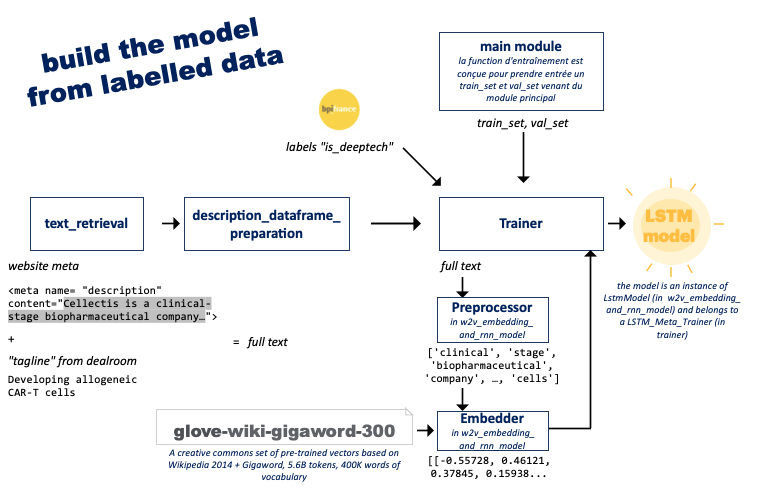

In [4]:
Image("img/train_model.png")

## module trainer
It defines the LSTM_Meta_trainer class, that will handle a training based on an existing data set.
The `merge_df` function is here to help us in training the main model and this NLP model on the same training sets and measuring their performance on the same test set.

The functions of the LSTM_Meta_trainer class are:

+ **lstm_training**(self, train_set, val_set): trains on sets received from the main model, using its own text data stored in self.df_meta_categorical
+ **lstm_predict**(self, X_test_from_main_module): similarly, returns a prediction on a test set (using only its id list really)
+ **save_model**(self, target_file="deeptech_NLP_model"): saves a trained model to disk, in a keras format that stores the model in a folder

The `main_trainer` function can be used to re-train the model on an updated set of data.

The `preparing_results` and `from_Cathsfile_to_mine` functions you can ignore, they helped us measure a common score on similar sets for the two models.

**The module trainer relies on the following modules:**

## module text_processing
Contains a variety of text processing functions, 

+ most of which used in the `text_preprocessing`function, itself used by **trainer** 
+ one used in data preparation: remove_own_name
+ some unused: stem and lemmatize, remove_dealroom_phrase

## module w2v_embedding_and_rnn_model
This important module contains:

+ the Preprocessor, Embedder and LstmModel classes on which the **trainer** relies heavily
+ the `init_and_compile_model` function that is used by LstmModel to initialize itself
+ the `pad_X` function that is used by LstmModel to pad its X before fitting or predicting

## module utils_w2v_rnn
This module contains functions that help measure and visualize the performance of the trained model on a vaidation set (same validation set as used for EarlyStopping). The **trainer** module uses them to provide user feedback at the end of the training. 

---
# Using the model for prediction

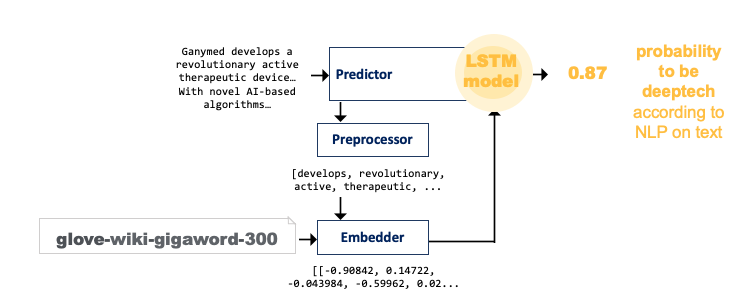

In [5]:
Image("img/predict_with_model.png")

## module predictor
The Predictor class loads a trained model (as saved by the trainer) and uses it to make a prediction on a pandas Series of strings, each strong being a description of a company. It returns predictions as to whether or not the company is a deeptech in the BPI's understanding.

## API
The model is available as an API (built with Fast API, containerized on Docker, hosted and ran on Google Cloud Platform), that can be queried with the following code (replace companies names and descriptions as needed).
When it has not been called recently, the API has some loading to do so be patient. Subsequent calls should be faster.

In [9]:
import requests
url = "https://text-deeptech-2w2uaoep4a-ew.a.run.app/pred"
params = {"company_descriptions": 
          {"Alice&Bob": "We build Universal, Error-free, Quantum Computers to help industries and researchers solve the hardest problems",
           "Flying Whales": "Developing the 'Large Capacity Airship 60 tons' for low-cost, point-to-point transport of heavy or bulky loads",
           "Doctolib": "An appointment online to a doctor or dentist",
           "Ganymed_Robotics": "Develops advanced robotics technologies for orthopedic surgeons"}}
response = requests.post(url, json=params)
response.json()

{'Alice&Bob': 0.7481144666671753,
 'Flying Whales': 0.5127061009407043,
 'Doctolib': 0.07383999973535538,
 'Ganymed_Robotics': 0.8783800005912781}

Note that Alice&Bob, Flying Whales and Doctolib were in the original database (but the model may or may not have been trained on them, depending on the random test and train splits). Ganymed was not in the base and has no website. Running the API on its Dealroom tagline still gives good results.

The API currently runs on my (Clémence Knaébel) Google Cloud Platform (available until February 2021). To be determined whether we transfer it to a BPI account. 